# Notes - weighting recorded DS births

In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from graphviz import Digraph
from sympy.physics.units import magnetic_density
from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

In [6]:
con.close()
con = duckdb.connect("./data/us_births.db") #, read_only=True)

In [3]:
weights_df = pd.read_csv("./us-births-ds-rec-weights.csv").convert_dtypes()
weights_df

,year,nhw,nhb,his,as_pi,ai_an,total
0,1989,1.858,2.8401,2.4956,3.4586,2.2252,2.0729
1,1990,2.0429,2.496,2.5259,3.0726,1.7313,2.1864
2,1991,2.1327,4.1453,3.1321,3.9852,2.5975,2.4734
3,1992,2.1559,3.7759,2.8107,3.3929,1.3557,2.4163
4,1993,2.1618,3.9442,3.05,3.6772,1.6801,2.4735
5,1994,2.247,4.4031,2.9457,3.4705,1.7887,2.5522
6,1995,2.3477,4.6167,3.0536,3.9467,2.1375,2.6733
7,1996,2.2568,3.6629,3.0506,3.4698,3.8211,2.5543
8,1997,2.3421,4.0062,3.0959,3.2728,2.9714,2.6442
9,1998,2.1455,3.9135,2.9038,2.5507,4.8005,2.4471


In [ ]:
con.execute("DROP TABLE IF EXISTS ds_rec_weights;")
con.execute(
    """
    CREATE TABLE ds_rec_weights AS
    SELECT * FROM weights_df
    """
)

In [7]:
con.execute(
    """
    UPDATE us_births AS b
    SET ds_rec_weight =
            CASE
                WHEN b.down_ind = 1 AND b.mracehisp_c = 1 THEN w.nhw
                WHEN b.down_ind = 1 AND b.mracehisp_c = 2 THEN w.nhb
                WHEN b.down_ind = 1 AND b.mracehisp_c = 3 THEN w.ai_an
                WHEN b.down_ind = 1 AND b.mracehisp_c = 4 THEN w.as_pi
                WHEN b.down_ind = 1 AND b.mracehisp_c = 5 THEN w.his
                WHEN b.down_ind = 1 THEN w.total
                ELSE 0
                END FROM ds_rec_weights AS w
    WHERE b.year = w.year;
    """
)

In [8]:
weighted_est_df = con.execute(
    """
    SELECT
        b.year,
        SUM (b.ds_rec_weight) as case_weighted,
        SUM (b.p_ds_lb_wt) as year_prev_est,
        SUM (b.p_ds_lb_wt_mage) as year_age_prev_est,
        sum(e.prevalence / 10000.0) as year_ethn_prev_est,
        SUM (b.p_ds_lb_nt) as no_term_age_est,
        SUM (b.p_ds_lb_nt * (1 - r.reduction)) as term_under_est,
        SUM (b.down_ind) as down_ind,
    FROM
        us_births as b
        LEFT JOIN us_births_est_prevalence_ethnicity e
            ON b.year = e.year AND b.mracehisp_c = e.mracehisp_c
        JOIN reduction_rate_year r
            ON b.year = r.year
    WHERE
        b.year >= 1989
    GROUP BY
        b.year
    ORDER BY
        b.year
    """
).df()
weighted_est_df.to_csv(f"./output/us_births_weighted_ds_estimates_year.csv", index=False)
weighted_est_df

,year,case_weighted,year_prev_est,year_age_prev_est,year_ethn_prev_est,no_term_age_est,term_under_est,down_ind
0,1989,4050.4912,4199.429334,4199.990792,NaN,5435.804076,4201.805434,1954.0
1,1990,4335.6191,4391.877435,4391.978707,NaN,5716.629219,4394.402030,1983.0
2,1991,4431.3788,4432.223334,4431.747206,NaN,5794.837984,4433.762142,1791.0
3,1992,4387.8900,4407.190524,4406.742137,NaN,5888.002906,4408.741077,1816.0
4,1993,4360.7702,4376.943639,4376.743186,NaN,5957.920280,4378.555635,1763.0
5,1994,4354.0739,4360.531350,4360.634964,NaN,6063.337957,4361.998372,1706.0
6,1995,4384.1317,4375.276452,4374.942505,NaN,6140.807701,4376.564560,1640.0
7,1996,4283.5259,4280.466526,4280.770270,NaN,6279.330012,4281.998480,1677.0
8,1997,4397.3707,4365.985796,4365.918492,NaN,6396.586350,4367.179471,1663.0
9,1998,4070.9458,4481.738112,4482.158335,NaN,6598.625178,4483.180629,1682.0


In [9]:
weighted_est_ages_df = con.execute(
    """
    SELECT
        b.mage_c,
        SUM (b.ds_rec_weight) as case_weighted,
        SUM (b.p_ds_lb_wt) as year_prev_est,
        SUM (b.p_ds_lb_wt_mage) as year_age_prev_est,
        SUM (e.prevalence / 10000.0) as year_ethn_prev_est,
        SUM (b.p_ds_lb_nt) as no_term_age_est,
        SUM (b.p_ds_lb_nt * (1 - r.reduction)) as term_under_est,
        SUM (b.down_ind) as down_ind,
    FROM
        us_births as b
        LEFT JOIN us_births_est_prevalence_ethnicity e
            ON b.year = e.year AND b.mracehisp_c = e.mracehisp_c
        JOIN reduction_rate_year r
            ON b.year = r.year
    WHERE
        b.year >= 1989
    GROUP BY
        b.mage_c
    ORDER BY
        b.mage_c
    """
).df()
weighted_est_ages_df

,mage_c,case_weighted,year_prev_est,year_age_prev_est,year_ethn_prev_est,no_term_age_est,term_under_est,down_ind
0,10,0.0000,0.144027,0.111466,0.007811,0.088619,0.066471,0.0
1,11,0.0000,0.473000,0.342853,0.068694,0.282449,0.205734,0.0
2,12,5.3307,6.550478,4.070176,2.597570,3.689418,2.580493,2.0
3,13,21.5234,42.703773,27.261159,16.168953,24.230647,17.007112,7.0
4,14,123.7599,217.172097,138.249868,92.071911,122.848433,86.000604,39.0
5,15,446.5062,699.278512,442.755666,314.587282,394.728337,275.688307,163.0
6,16,1015.9902,1567.440186,983.481986,743.190148,883.214695,615.226338,364.0
7,17,1659.7742,2760.999387,1710.508098,1360.690725,1554.139056,1079.562129,611.0
8,18,2491.6319,4340.608408,2636.108372,2223.572822,2438.841868,1687.403650,948.0
9,19,3665.2405,6140.474708,3635.080810,3226.623831,3446.865490,2373.471894,1389.0


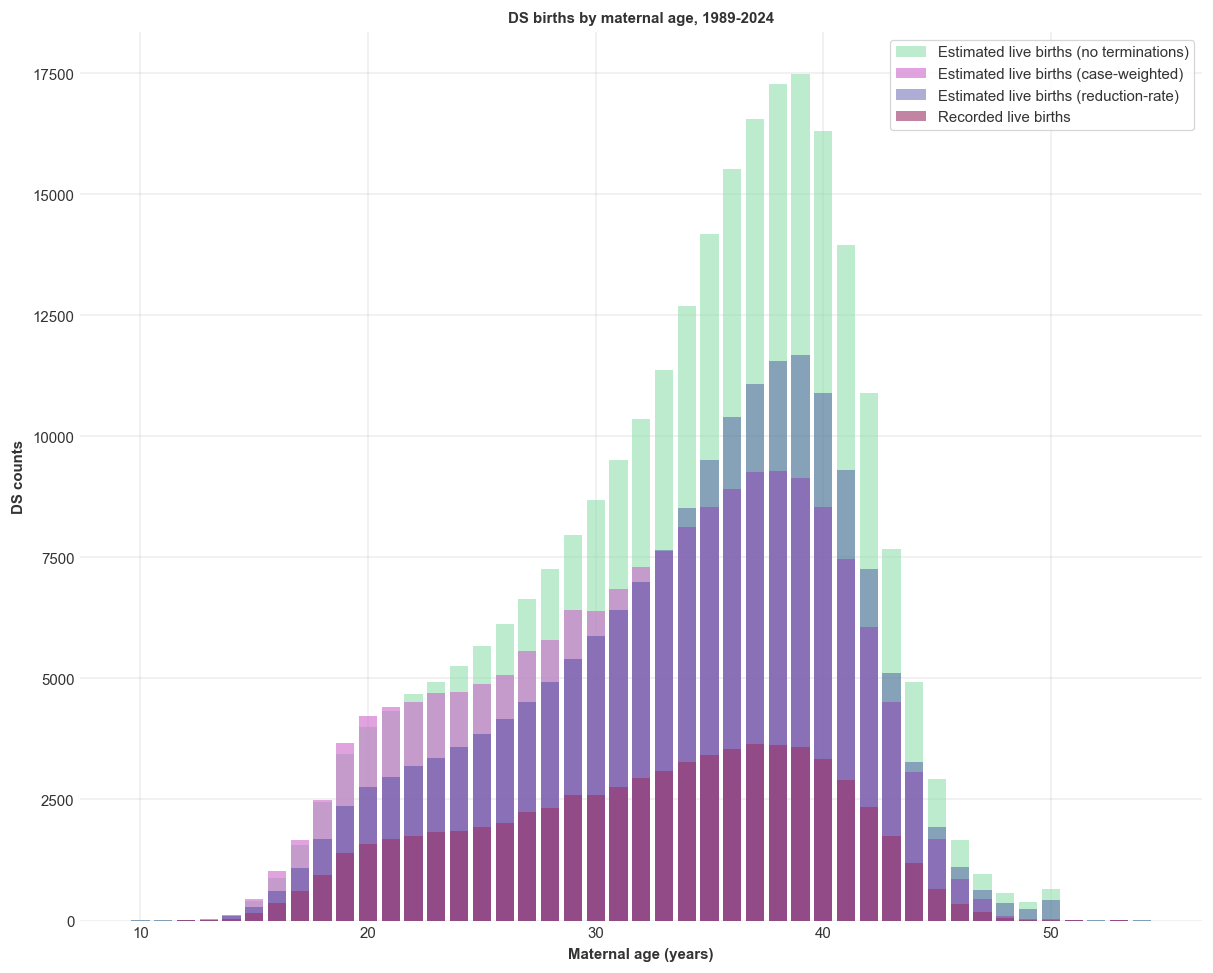

In [10]:
plt.figure(figsize=(10, 8))
plt.bar(weighted_est_ages_df["mage_c"], weighted_est_ages_df["no_term_age_est"], color="#90e0ac99", label="Estimated live births (no terminations)")
plt.bar(weighted_est_ages_df["mage_c"], weighted_est_ages_df["case_weighted"], color="#cc66cc99", label="Estimated live births (case-weighted)")
plt.bar(weighted_est_ages_df["mage_c"], weighted_est_ages_df["term_under_est"], color="#33339966", label="Estimated live births (reduction-rate)")
plt.bar(weighted_est_ages_df["mage_c"], weighted_est_ages_df["down_ind"], color="#99336699", label="Recorded live births")
plt.title("DS births by maternal age, 1989-2024")
plt.xlabel("Maternal age (years)")
plt.ylabel("DS counts")
plt.legend()